# Irony Detection in English Tweets

* João Dossena - UP201800174
* João Rosário - UP201806334
* João Sousa - UP201806613

MIEIC, Class 8, Group 14

## Project Specification

The project is made up of two subtasks.
In the first one the objective is the detection of irony given a tweet in English, marking it out either with a value of 0 or 1 if irony is absent or not, respectively.
In the second subtask the goal is to classify the type of irony into 4 classes:
1. verbal irony realized through a polarity contrast
2. verbal irony without such a polarity contrast (i.e., other verbal irony)
3. descriptions of situational irony
4. non-irony

The datasets provided consisted of a set of entries where the first column was the tweet index, the second one was the label (either 0 or 1, or 0, 1, 2 or 3 depending on the task) in the case of the training data or the tweet text which corresponds to the third column in the training datasets.

## Required Libraries

* ... todo

## Exploratory Data Analysis

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns #visualisation
import matplotlib.pyplot as plt #visualisation
%matplotlib inline 
sns.set(color_codes=True)

In [2]:
# Get data from file
def readData(path_train, path_test):
    df = pd.read_csv(path_train, sep="\t")
    test_df = pd.read_csv(path_test, sep="\t")
    print("Data Read Successfully")
    return (df, test_df)

In [3]:
(train_df, test_df) = readData("../datasets/train/train-taskA.txt", "../datasets/test/gold_test_taskA.txt")

Data Read Successfully


In [4]:
# train_df = pd.read_csv("../datasets/train/train-taskA.txt", sep="\t")
train_df.shape

(3817, 3)

In [5]:
# test_df = pd.read_csv("../datasets/test/gold_test_taskA.txt", sep="\t")
test_df.shape

(784, 3)

In [6]:
train_df.head()

,Tweet index,Label,Tweet text
0,1,1,Sweet United Nations video. Just in time for C...
1,2,1,@mrdahl87 We are rumored to have talked to Erv...
2,3,1,Hey there! Nice to see you Minnesota/ND Winter...
3,4,0,3 episodes left I'm dying over here
4,5,1,I can't breathe! was chosen as the most notabl...


In [7]:
# checking if there are any null values present in the dataset
train_df.isnull().sum()

Tweet index    0
Label          0
Tweet text     0
dtype: int64

Label
0    1916
1    1901
Name: Tweet text, dtype: int64


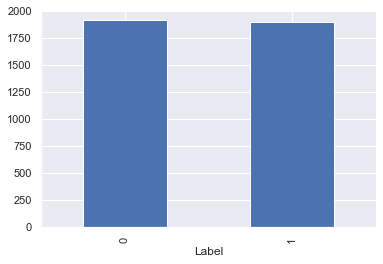

In [8]:
print(train_df.groupby('Label')['Tweet text'].count())
train_df.groupby('Label')['Tweet text'].count().plot.bar(ylim=0)
plt.show()

In [9]:
'''
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]
common_words = get_top_n_words(train_df['Tweet text'], -1)
for word, freq in common_words:
    print(word, freq)
'''


"\ndef get_top_n_words(corpus, n=None):\n    vec = CountVectorizer().fit(corpus)\n    bag_of_words = vec.transform(corpus)\n    sum_words = bag_of_words.sum(axis=0) \n    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]\n    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)\n    return words_freq[:n]\ncommon_words = get_top_n_words(train_df['Tweet text'], -1)\nfor word, freq in common_words:\n    print(word, freq)\n"

## Text processing

In [10]:
import re
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import numpy as np
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score


def processing(Corpus):
    # Step - a : Remove blank rows if any.
    Corpus['Tweet text'].dropna(inplace=True)
    
    # Step - b : Change all the text to lower case. This is required as python interprets 'dog' and 'DOG' differently
    Corpus['Tweet text'] = [entry.lower() for entry in Corpus['Tweet text']]
    
    # Step - c : Tokenization : In this each entry in the corpus will be broken into set of words
    Corpus['Tweet text'] = [re.sub('@[a-zA-Z0-9_]+|https?://t.co/[a-zA-Z0-9_]+|[^a-zA-Z]', ' ', entry) for entry in Corpus['Tweet text']]
    
    # Step - c2 : Remove usernames 
    Corpus['Tweet text']= [word_tokenize(entry) for entry in Corpus['Tweet text']]
    
    # Step - d : Remove Stop words, Non-Numeric and perfom Word Stemming/Lemmenting.# WordNetLemmatizer requires Pos tags to understand if the word is noun or verb or adjective etc. By default it is set to Noun
    tag_map = defaultdict(lambda : wn.NOUN)
    tag_map['J'] = wn.ADJ
    tag_map['V'] = wn.VERB
    tag_map['R'] = wn.ADV
    for index,entry in enumerate(Corpus['Tweet text']):
        
        # Declaring Empty List to store the words that follow the rules for this step
        Final_words = []
        
        # Initializing WordNetLemmatizer()
        word_Lemmatized = WordNetLemmatizer()
        
        # pos_tag function below will provide the 'tag' i.e if the word is Noun(N) or Verb(V) or something else.
        for word, tag in pos_tag(entry):
            # Below condition is to check for Stop words and consider only alphabets
            if word not in stopwords.words('english') and word.isalpha():
                word_Final = word_Lemmatized.lemmatize(word,tag_map[tag[0]])
                Final_words.append(word_Final)
        # The final processed set of words for each iteration will be stored in 'text_final'
        Corpus.loc[index,'text_final'] = str(Final_words)
    
    # print(Corpus['text_final'])
    print("Processed")
    return Corpus

In [11]:
corpus = processing(train_df)
test_corpus = processing(test_df)

Processed
Processed


In [12]:
from sklearn.feature_extraction.text import CountVectorizer

# Create bag-of-words model
def bagOfWords(df, corpus):
    vectorizer = CountVectorizer(max_features = 250) # original = 1500
    X = vectorizer.fit_transform(corpus).toarray()
    y = df.iloc[:,1].values

    print("Bag of words done!")

    print("bag_of_words: 250 max_features")
    return (X, y)

In [13]:
from imblearn.over_sampling import SMOTE

# Oversampling Method
def smote(X_train, y_train):

    sm = SMOTE()
    X_train, y_train = sm.fit_resample(X_train, y_train)

    print("Oversampling with Smote")
    return (X_train, y_train)

In [14]:
Train_X = corpus['text_final']
Train_Y = corpus.iloc[:,1].values

Test_X = test_corpus['text_final']
Test_Y = test_corpus.iloc[:,1].values

In [15]:
print("TfidfVectorizer max_features=5000")
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(corpus['text_final'])
Train_X_Tfidf = Tfidf_vect.transform(Train_X)
Test_X_Tfidf = Tfidf_vect.transform(Test_X)

TfidfVectorizer max_features=5000


In [16]:
# Oversampling
(Train_X_Tfidf, Train_Y) = smote(Train_X_Tfidf, Train_Y)

Oversampling with Smote


## Algorithms and Parameter Tuning

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV

import time

### Support Vector Machines

In [18]:
from sklearn.svm import SVC

In [219]:
# SVM default
def svm_default(X_train, X_test, y_train, y_test):
    
    print("SVM (default parameters)")
    classifier = SVC()
    return svm(classifier, X_train, X_test, y_train, y_test)

# SVM optimized
def svm_optimized(X_train, X_test, y_train, y_test):
    
    # 'C': 1, 'kernel': 'sigmoid'
    print("SVM ('C': 1, 'kernel': 'sigmoid')")
    classifier = SVC(C=1, kernel='sigmoid')
    return svm(classifier, X_train, X_test, y_train, y_test)
    

# SVM
def svm(classifier, X_train, X_test, y_train, y_test):

    # 'C': 1, 'kernel': 'linear'
    # classifier = SVC(C=1, kernel='linear')
    
    time_0 = time.time()
    classifier.fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,3))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    predict_time = str(round(time.time()-time_1,3))

    # print("SVM ('C': 1, 'kernel': 'linear')")
    
    print("Training Time: " + training_time)
    print("Predict Time: " + predict_time)
    
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_true=Test_Y, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    return (classification_report(y_test, y_pred, output_dict=True), training_time, predict_time, y_test, y_pred)
    
    # print(confusion_matrix(y_test, y_pred))
    # print('Accuracy: ', accuracy_score(y_test, y_pred))
    # print('Precision: ', precision_score(y_test, y_pred))
    # print('Recall: ', recall_score(y_test, y_pred))
    # print('F1: ', f1_score(y_test, y_pred))

SVM ('C': 1, 'kernel': 'sigmoid')
Training Time: 0.744
Predict Time: 0.112
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       473
           1       0.52      0.61      0.56       311

    accuracy                           0.62       784
   macro avg       0.62      0.62      0.62       784
weighted avg       0.64      0.62      0.63       784



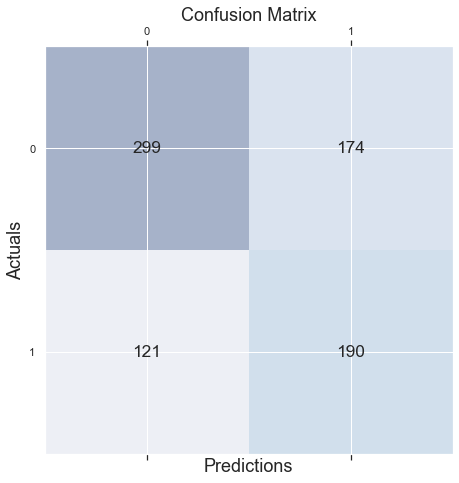


-----

SVM (default parameters)
Training Time: 0.859
Predict Time: 0.149
              precision    recall  f1-score   support

           0       0.71      0.68      0.70       473
           1       0.55      0.59      0.57       311

    accuracy                           0.64       784
   macro avg       0.63      0.63      0.63       784
weighted avg       0.65      0.64      0.65       784



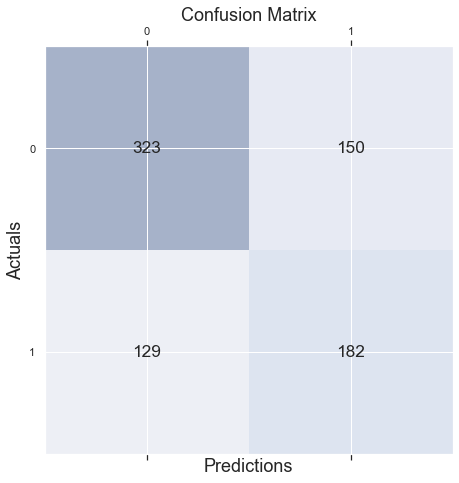

In [222]:
(svc_optimized, svc_optimized_train_time, svc_optimized_predict_time, svc_optimized_y_test, svc_optimized_y_pred) = svm_optimized(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)
print("\n-----\n")
(svc_for_graph, svc_train_time, svc_predict_time, svc_y_test, svc_y_pred) = svm_default(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

# print(svm_default(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y))

In [148]:
def findSVC(X_train, X_test, y_train, y_test):

    tuned_parameters = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
                        'C': [0.5, 1.0, 2.0]
                    }

    clf = GridSearchCV(SVC(), tuned_parameters, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)

    print('Best parameters found:\n', clf.best_params_)

    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_true, y_pred = y_test , clf.predict(X_test)

    print('Results on the test set:')
    print(classification_report(y_true, y_pred))
    
    return classification_report(y_test, y_pred, output_dict=True)

In [149]:
svc_tunning_for_graph = findSVC(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

Best parameters found:
 {'C': 1.0, 'kernel': 'sigmoid'}
0.612 (+/-0.028) for {'C': 0.5, 'kernel': 'linear'}
0.529 (+/-0.004) for {'C': 0.5, 'kernel': 'poly'}
0.609 (+/-0.032) for {'C': 0.5, 'kernel': 'rbf'}
0.610 (+/-0.026) for {'C': 0.5, 'kernel': 'sigmoid'}
0.609 (+/-0.037) for {'C': 1.0, 'kernel': 'linear'}
0.601 (+/-0.018) for {'C': 1.0, 'kernel': 'poly'}
0.614 (+/-0.036) for {'C': 1.0, 'kernel': 'rbf'}
0.615 (+/-0.034) for {'C': 1.0, 'kernel': 'sigmoid'}
0.602 (+/-0.031) for {'C': 2.0, 'kernel': 'linear'}
0.598 (+/-0.009) for {'C': 2.0, 'kernel': 'poly'}
0.613 (+/-0.015) for {'C': 2.0, 'kernel': 'rbf'}
0.601 (+/-0.036) for {'C': 2.0, 'kernel': 'sigmoid'}
Results on the test set:
              precision    recall  f1-score   support

           0       0.71      0.63      0.67       473
           1       0.52      0.61      0.56       311

    accuracy                           0.62       784
   macro avg       0.62      0.62      0.62       784
weighted avg       0.64      0.62  

In [143]:
# import matplotlib.patches as mpatches

# X = np.arange(3)
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.bar(X + 0.5, svc_for_graph['accuracy'], color = '#003f5c', width = 0.25, tick_label=['DT', 'SVM', 'KNN'])
# green_patch = mpatches.Patch(color='#ffa600', label='Oversampled dataset')

# plt.legend(handles=[green_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

# plt.xlabel("Algorithm")
# plt.ylabel("Accuracy")
# plt.title("Accuracy obtained by each algorithm")

### Linear Model - Perceptron

In [224]:
from sklearn.linear_model import Perceptron

# Perceptron
def perceptron(X_train, X_test, y_train, y_test):
    classifier = Perceptron()
    
    time_0 = time.time()
    classifier.fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,5))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    
    predict_time = str(round(time.time()-time_1,5))
    
    print("Training Time: " + training_time)
    print("Predict Time: " + predict_time)

    print("Perceptron")
#     print(confusion_matrix(y_test, y_pred))
#     print('Accuracy: ', accuracy_score(y_test, y_pred))
#     print('Precision: ', precision_score(y_test, y_pred))
#     print('Recall: ', recall_score(y_test, y_pred))
#     print('F1: ', f1_score(y_test, y_pred))

    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_true=Test_Y, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    return (classification_report(y_test, y_pred, output_dict=True), training_time, predict_time, y_test, y_pred)

Training Time: 0.006
Predict Time: 0.0
Perceptron
              precision    recall  f1-score   support

           0       0.72      0.60      0.65       473
           1       0.52      0.66      0.58       311

    accuracy                           0.62       784
   macro avg       0.62      0.63      0.62       784
weighted avg       0.64      0.62      0.62       784



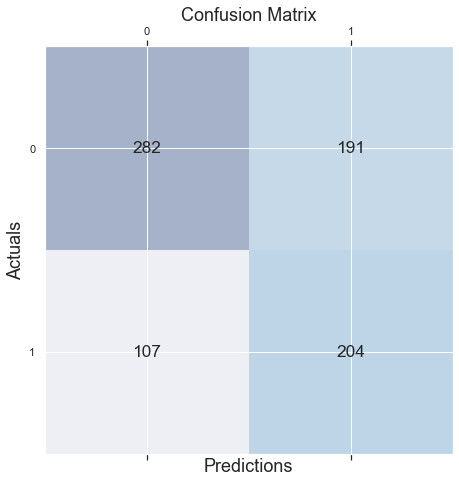

In [225]:
(perceptron_default_for_graph, perceptron_train_time, perceptron_predict_time, perceptron_y_test, perceptron_y_pred) = perceptron(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

In [160]:
def findPerceptron(X_train, X_test, y_train, y_test):
    
    parameter_space = {
        'penalty': ['l2', 'l1', 'elasticnet'],
        'alpha': [0.05, 0.0001],
        'max_iter': [100, 200, 500, 1000, 2000],
    }

    clf = GridSearchCV(Perceptron(), parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)

    # Best paramete set
    print('Best parameters found:\n', clf.best_params_)

    # All results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_true, y_pred = y_test , clf.predict(X_test)

    print('Results on the test set:')
    print(classification_report(y_true, y_pred))
    
    return classification_report(y_test, y_pred, output_dict=True)

In [161]:
perceptron_tunning_for_graph = findPerceptron(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

Best parameters found:
 {'alpha': 0.0001, 'max_iter': 100, 'penalty': 'elasticnet'}
0.531 (+/-0.022) for {'alpha': 0.05, 'max_iter': 100, 'penalty': 'l2'}
0.500 (+/-0.001) for {'alpha': 0.05, 'max_iter': 100, 'penalty': 'l1'}
0.500 (+/-0.001) for {'alpha': 0.05, 'max_iter': 100, 'penalty': 'elasticnet'}
0.531 (+/-0.022) for {'alpha': 0.05, 'max_iter': 200, 'penalty': 'l2'}
0.500 (+/-0.001) for {'alpha': 0.05, 'max_iter': 200, 'penalty': 'l1'}
0.500 (+/-0.001) for {'alpha': 0.05, 'max_iter': 200, 'penalty': 'elasticnet'}
0.531 (+/-0.022) for {'alpha': 0.05, 'max_iter': 500, 'penalty': 'l2'}
0.500 (+/-0.001) for {'alpha': 0.05, 'max_iter': 500, 'penalty': 'l1'}
0.500 (+/-0.001) for {'alpha': 0.05, 'max_iter': 500, 'penalty': 'elasticnet'}
0.531 (+/-0.022) for {'alpha': 0.05, 'max_iter': 1000, 'penalty': 'l2'}
0.500 (+/-0.001) for {'alpha': 0.05, 'max_iter': 1000, 'penalty': 'l1'}
0.500 (+/-0.001) for {'alpha': 0.05, 'max_iter': 1000, 'penalty': 'elasticnet'}
0.531 (+/-0.022) for {'alpha'

### Neural Networks

In [101]:
from sklearn.neural_network import MLPClassifier

# classifier = MLPClassifier(activation='tanh', alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate= 'adaptive', max_iter=200, solver='sgd')

In [227]:
# Multi Layered Perceptron
def mlp(X_train, X_test, y_train, y_test):
    # 'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50), 'learning_rate': 'adaptive', 'solver': 'sgd'
    
    time_0 = time.time()
    MLPClassifier().fit(X_train, y_train)
    training_time = str(round(time.time()-time_0,5))
    
    time_1 = time.time()
    y_pred = classifier.predict(X_test)
    predict_time = str(round(time.time()-time_1,5))
    
    print("Training Time: " + training_time)
    print("Predict Time: " + predict_time)

#     print("MLP activation='tanh', alpha=0.0001, hidden_layer_sizes=(50, 50, 50), learning_rate= 'adaptive', max_iter=200, solver='sgd'")
#     print(confusion_matrix(y_test, y_pred))
#     print('Accuracy: ', accuracy_score(y_test, y_pred))
#     print('Precision: ', precision_score(y_test, y_pred))
#     print('Recall: ', recall_score(y_test, y_pred))
#     print('F1: ', f1_score(y_test, y_pred))
    
    print(classification_report(y_test, y_pred))
    
    conf_matrix = confusion_matrix(y_true=Test_Y, y_pred=y_pred)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()
    
    return (classification_report(y_test, y_pred, output_dict=True), training_time, predict_time, y_test, y_pred)

Training Time: 58.65806
Predict Time: 0.001
              precision    recall  f1-score   support

           0       0.66      0.42      0.52       473
           1       0.43      0.67      0.53       311

    accuracy                           0.52       784
   macro avg       0.55      0.55      0.52       784
weighted avg       0.57      0.52      0.52       784



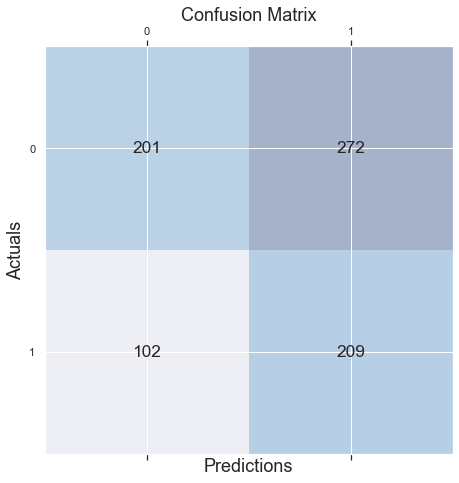

In [218]:
(mlp_default_for_graph, mlp_train_time, mlp_predict_time, mlp_y_test, mlp_y_pred) = mlp(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

In [121]:
# Finding the best parameters for MLP
def findMlp(X_train, X_test, y_train, y_test):
#     print("'hidden_layer_sizes': [(20,20), (50,50), (50,50,50), (10,10)],")
#     print("'activation': ['tanh'],")
#     print("'alpha': [0.05, 0.0001],")
#     print("'learning_rate': ['adaptive'],")
#     print("'max_iter': [200, 500],")
    
    parameter_space = {
        'hidden_layer_sizes': [(20,20), (50,50), (50,50,50), (10,10), (100)],
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'solver': ['sgd'],
        'alpha': [0.05, 0.0001],
        'learning_rate': ['constant', 'invscaling', 'adaptive'],
        'max_iter': [100, 200, 500],
    }

    clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=3)
    clf.fit(X_train, y_train)

    # Best paramete set
    print('Best parameters found:\n', clf.best_params_)

    # All results
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    y_true, y_pred = y_test , clf.predict(X_test)

    print('Results on the test set:')
    print(classification_report(y_true, y_pred))
    
    return classification_report(y_test, y_pred, output_dict=True)

In [122]:
mlp_tunning_for_graph = findMlp(Train_X_Tfidf, Test_X_Tfidf, Train_Y, Test_Y)

Best parameters found:
 {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (10, 10), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'sgd'}
0.515 (+/-0.044) for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'max_iter': 100, 'solver': 'sgd'}
0.501 (+/-0.019) for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'max_iter': 200, 'solver': 'sgd'}
0.529 (+/-0.010) for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'constant', 'max_iter': 500, 'solver': 'sgd'}
0.500 (+/-0.000) for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'invscaling', 'max_iter': 100, 'solver': 'sgd'}
0.500 (+/-0.000) for {'activation': 'identity', 'alpha': 0.05, 'hidden_layer_sizes': (20, 20), 'learning_rate': 'invscaling', 'max_iter': 200, 'solver': 'sgd'}
0.500 (+/-0.001) for {'activation': 'identity

### Comparisons

In [184]:
import matplotlib.patches as mpatches

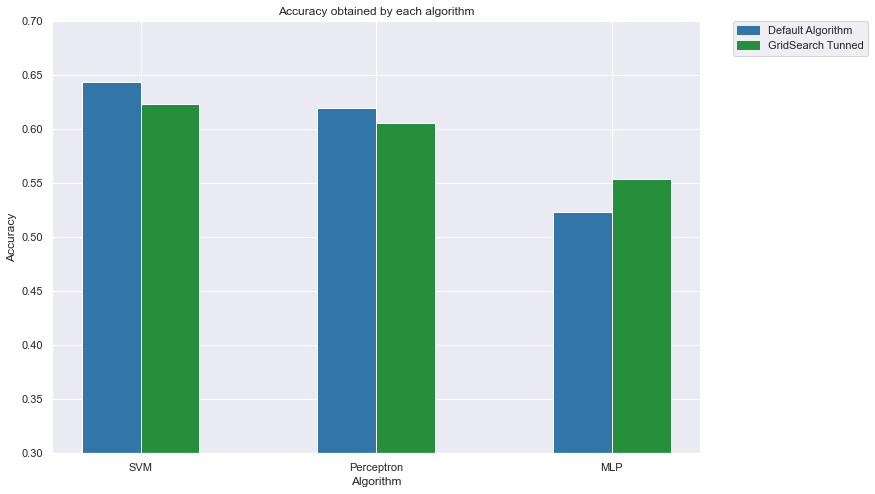

In [260]:
data = [
            [svc_for_graph['accuracy'], perceptron_default_for_graph['accuracy'], mlp_default_for_graph['accuracy']],
            [svc_tunning_for_graph['accuracy'], perceptron_tunning_for_graph['accuracy'], mlp_tunning_for_graph['accuracy']]
       ]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X + 0.0, data[0], color = '#3275a8', width = 0.25, tick_label=['SVM', 'Perceptron', 'MLP'])
ax.bar(X + 0.25, data[1], color = '#258f3c', width = 0.25)

plt.xticks([0.125,1.125,2.125], ['SVM', 'Perceptron', 'MLP'])

default_patch = mpatches.Patch(color='#3275a8', label='Default Algorithm')
tunned_patch = mpatches.Patch(color='#258f3c', label='GridSearch Tunned')
plt.legend(handles=[default_patch, tunned_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.ylim(0.3, 0.7) # y limits

plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.title("Accuracy obtained by each algorithm")

print()

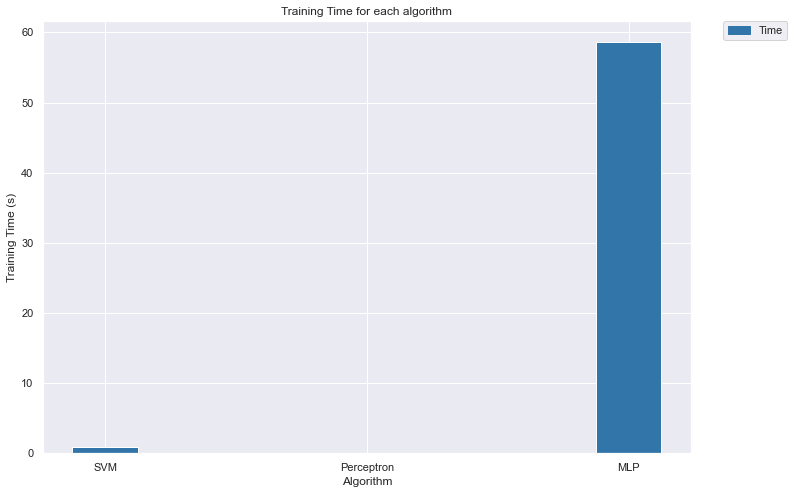

In [253]:
data = [
            [float(svc_train_time), float(perceptron_train_time), float(mlp_train_time)]
       ]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X, data[0], color = '#3275a8', width = 0.25, tick_label=['SVM', 'Perceptron', 'MLP'])

default_patch = mpatches.Patch(color='#3275a8', label='Time')
plt.legend(handles=[default_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.ylim(0.3, 0.7) # y limits

plt.xlabel("Algorithm")
plt.ylabel("Training Time (s)")
plt.title("Training Time for each algorithm")

print()

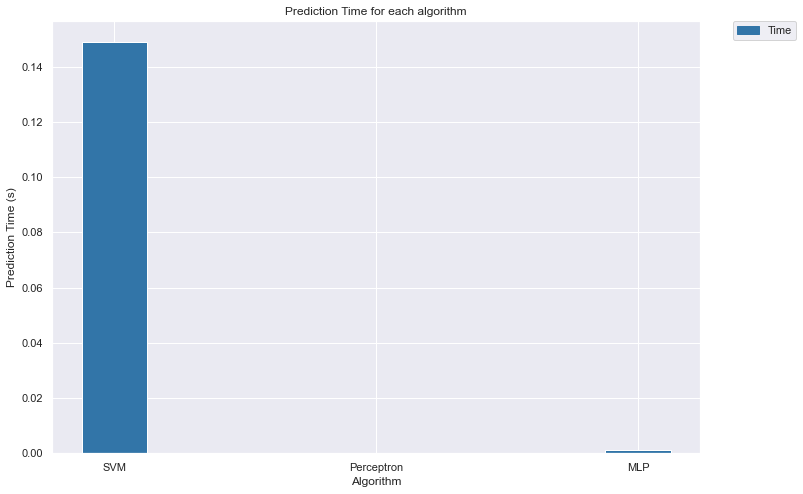

In [246]:
data = [
            [float(svc_predict_time), float(perceptron_predict_time), float(mlp_predict_time)]
       ]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X, data[0], color = '#3275a8', width = 0.25, tick_label=['SVM', 'Perceptron', 'MLP'])

default_patch = mpatches.Patch(color='#3275a8', label='Time')
plt.legend(handles=[default_patch], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.ylim(0.3, 0.7) # y limits

plt.xlabel("Algorithm")
plt.ylabel("Prediction Time (s)")
plt.title("Prediction Time for each algorithm")

print()

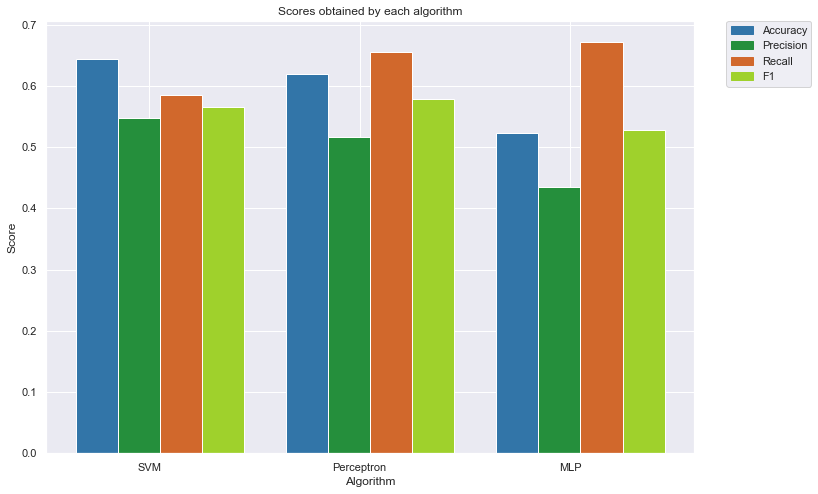

In [250]:
# print(confusion_matrix(y_test, y_pred))
# print('Accuracy: ', accuracy_score(y_test, y_pred))
# print('Precision: ', precision_score(y_test, y_pred))
# print('Recall: ', recall_score(y_test, y_pred))
# print('F1: ', f1_score(y_test, y_pred))

data = [
            [accuracy_score(svc_y_test, svc_y_pred), accuracy_score(perceptron_y_test, perceptron_y_pred), accuracy_score(mlp_y_test, mlp_y_pred)],
            [precision_score(svc_y_test, svc_y_pred), precision_score(perceptron_y_test, perceptron_y_pred), precision_score(mlp_y_test, mlp_y_pred)],
            [recall_score(svc_y_test, svc_y_pred), recall_score(perceptron_y_test, perceptron_y_pred), recall_score(mlp_y_test, mlp_y_pred)],
            [f1_score(svc_y_test, svc_y_pred), f1_score(perceptron_y_test, perceptron_y_pred), f1_score(mlp_y_test, mlp_y_pred)]
       ]

X = np.arange(3)
fig = plt.figure()
ax = fig.add_axes([0,0,1.5,1.5])
ax.bar(X + 0.0, data[0], color = '#3275a8', width = 0.2)
ax.bar(X + 0.2, data[1], color = '#258f3c', width = 0.2)
ax.bar(X + 0.40, data[2], color = '#d1682c', width = 0.2)
ax.bar(X + 0.6, data[3], color = '#9fd12c', width = 0.2)

plt.xticks([0.25,1.25,2.25], ['SVM', 'Perceptron', 'MLP'])

default_patch = mpatches.Patch(color='#3275a8', label='Accuracy')
tunned_patch = mpatches.Patch(color='#258f3c', label='Precision')
tunned_patch_2 = mpatches.Patch(color='#d1682c', label='Recall')
tunned_patch_3 = mpatches.Patch(color='#9fd12c', label='F1')
plt.legend(handles=[default_patch, tunned_patch, tunned_patch_2, tunned_patch_3], bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
# plt.ylim(0.3, 0.7) # y limits

plt.xlabel("Algorithm")
plt.ylabel("Score")
plt.title("Scores obtained by each algorithm")

print()